In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import os, time, math, tqdm, itertools
import matplotlib.pyplot as plt

import seaborn as sns


from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_selection import RFECV, SequentialFeatureSelector

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn import metrics


import numpy as np
from keras.layers import Dense, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.models import Model
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.layers import SpatialDropout1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import LSTM, GRU, SimpleRNN

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

2023-07-24 06:27:58.501330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 06:27:59.409488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
print("Tensorflow Verstion", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow Verstion 2.12.1
Num GPUs Available:  1


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9546631534080723172
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10750328832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8014579658431932109
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:00:10.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-07-24 06:28:00.361049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 10252 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:00:10.0, compute capability: 8.6


In [4]:
# from google.colab import files
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Reading clean cicids2017 csv file
df = pd.read_csv('data/FeatureSelection_binaryClass.csv')

In [6]:
df.head(10)

,Unnamed: 0,DestinationPort,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthMin,FlowBytes/s,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATMin,...,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveStd,ActiveMax,ActiveMin,IdleStd,IdleMin,Label
0,0,49188.0,6.0,0.000000,0.0,3.000000e+06,4.0,4.0,4.000000,4.0,...,329.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0
1,1,49486.0,6.0,0.000000,0.0,4.000000e+06,3.0,3.0,3.000000,3.0,...,245.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0
2,2,88.0,0.0,111.967895,0.0,1.474548e+06,2.0,609.0,101.500000,2.0,...,8192.0,2053.0,5.0,20.0,0.0,0.0,0.0,0.0,0.0,0
3,3,88.0,0.0,136.153814,0.0,4.232082e+06,1.0,879.0,109.875000,1.0,...,8192.0,2053.0,7.0,20.0,0.0,0.0,0.0,0.0,0.0,0
4,4,88.0,0.0,682.482560,0.0,5.329310e+06,1.0,1160.0,145.000000,1.0,...,8192.0,2053.0,7.0,20.0,0.0,0.0,0.0,0.0,0.0,0
5,5,88.0,0.0,679.914876,0.0,1.074809e+07,1.0,524.0,87.333333,1.0,...,8192.0,2053.0,5.0,20.0,0.0,0.0,0.0,0.0,0.0,0
6,6,1034.0,6.0,0.000000,6.0,2.000000e+06,6.0,0.0,0.000000,0.0,...,2053.0,251.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0
7,7,88.0,0.0,688.214982,0.0,5.558534e+06,1.0,1119.0,139.875000,1.0,...,8192.0,2053.0,7.0,20.0,0.0,0.0,0.0,0.0,0.0,0
8,8,389.0,0.0,612.974034,0.0,5.378170e+05,1.0,18378.0,1531.500000,3.0,...,8192.0,0.0,11.0,20.0,0.0,0.0,0.0,0.0,0.0,0
9,9,88.0,0.0,105.626476,0.0,9.902676e+05,1.0,822.0,137.000000,1.0,...,8192.0,2053.0,5.0,20.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
print(df.shape)

(2425727, 42)


In [8]:
print(df.columns)

Index(['Unnamed: 0', 'DestinationPort', 'FwdPacketLengthMin',
       'FwdPacketLengthStd', 'BwdPacketLengthMin', 'FlowBytes/s', 'FlowIATMin',
       'FwdIATTotal', 'FwdIATMean', 'FwdIATMin', 'BwdIATTotal', 'BwdIATStd',
       'BwdIATMax', 'BwdIATMin', 'BwdHeaderLength', 'FwdPackets/s',
       'BwdPackets/s', 'MinPacketLength', 'PacketLengthVariance',
       'FINFlagCount', 'SYNFlagCount', 'PSHFlagCount', 'ACKFlagCount',
       'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount', 'Down/UpRatio',
       'AvgFwdSegmentSize', 'AvgBwdSegmentSize', 'FwdHeaderLength.1',
       'SubflowFwdBytes', 'SubflowBwdBytes', 'Init_Win_bytes_forward',
       'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward',
       'ActiveStd', 'ActiveMax', 'ActiveMin', 'IdleStd', 'IdleMin', 'Label'],
      dtype='object')


In [9]:
# drop columns Unnamed  0
df = df.drop(columns = 'Unnamed: 0')
df.head()

,DestinationPort,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthMin,FlowBytes/s,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATMin,BwdIATTotal,...,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveStd,ActiveMax,ActiveMin,IdleStd,IdleMin,Label
0,49188.0,6.0,0.000000,0.0,3.000000e+06,4.0,4.0,4.000,4.0,0.0,...,329.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0
1,49486.0,6.0,0.000000,0.0,4.000000e+06,3.0,3.0,3.000,3.0,0.0,...,245.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0
2,88.0,0.0,111.967895,0.0,1.474548e+06,2.0,609.0,101.500,2.0,467.0,...,8192.0,2053.0,5.0,20.0,0.0,0.0,0.0,0.0,0.0,0
3,88.0,0.0,136.153814,0.0,4.232082e+06,1.0,879.0,109.875,1.0,764.0,...,8192.0,2053.0,7.0,20.0,0.0,0.0,0.0,0.0,0.0,0
4,88.0,0.0,682.482560,0.0,5.329310e+06,1.0,1160.0,145.000,1.0,1022.0,...,8192.0,2053.0,7.0,20.0,0.0,0.0,0.0,0.0,0.0,0


# shuffle rows randomly

In [10]:
# considering only fifty percent of data
df=df.sample(frac=0.5).reset_index(drop=True)
df

,DestinationPort,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthMin,FlowBytes/s,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATMin,BwdIATTotal,...,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveStd,ActiveMax,ActiveMin,IdleStd,IdleMin,Label
0,8082.0,2.0,0.000000,6.0,266666.666700,2.0,49.0,4.900000e+01,49.0,2.0,...,1024.0,0.0,1.0,24.0,0.000000,0.0,0.0,0.000000e+00,0.0,0
1,80.0,0.0,189.466815,0.0,59.917134,155.0,120000000.0,5.214309e+06,240.0,120000000.0,...,8192.0,385.0,23.0,20.0,893006.710700,3094311.0,36181.0,1.285317e+06,5553267.0,0
2,53.0,51.0,0.000000,105.0,401.396161,3.0,124231.0,4.141033e+04,3.0,4.0,...,-1.0,-1.0,3.0,20.0,0.000000,0.0,0.0,0.000000e+00,0.0,0
3,443.0,0.0,23.276598,46.0,35.590928,3.0,4748401.0,1.187100e+06,3.0,0.0,...,255.0,360.0,2.0,20.0,0.000000,0.0,0.0,0.000000e+00,0.0,0
4,443.0,0.0,120.728387,0.0,97.736538,4.0,117090294.0,4.878762e+06,4.0,112034263.0,...,29200.0,1039.0,5.0,32.0,368072.941439,1281986.0,61036.0,1.654326e+04,9964050.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212859,9207.0,2.0,0.000000,6.0,238805.970100,18.0,49.0,4.900000e+01,49.0,48.0,...,1024.0,0.0,1.0,24.0,0.000000,0.0,0.0,0.000000e+00,0.0,0
1212860,80.0,0.0,141.529384,0.0,138.640010,2.0,86200000.0,1.720000e+07,242.0,86200000.0,...,0.0,235.0,2.0,20.0,0.000000,23987.0,23987.0,0.000000e+00,85200000.0,1
1212861,9712.0,6.0,0.000000,6.0,230769.230800,52.0,0.0,0.000000e+00,0.0,0.0,...,913.0,256.0,0.0,20.0,0.000000,0.0,0.0,0.000000e+00,0.0,0
1212862,53.0,29.0,0.000000,61.0,5768.676089,3.0,4.0,4.000000e+00,4.0,3.0,...,-1.0,-1.0,1.0,20.0,0.000000,0.0,0.0,0.000000e+00,0.0,0


In [11]:
# df = df.drop(columns=['Unnamed: 0'], axis=1)
# df.head()

# Train and Test Dataset

In [12]:
# put labels into y_train variable
Y = df["Label"]
# Drop 'label' column
X = df.drop(labels = ["Label"],axis = 1)

In [13]:
X.shape, Y.shape

((1212864, 40), (1212864,))

In [14]:
df['Label'].unique()

array([0, 1])

In [15]:
df["Label"].value_counts()

Label
0    1018104
1     194760
Name: count, dtype: int64

In [16]:
type(X)

pandas.core.frame.DataFrame

In [17]:
features = list(X.columns)
features

['DestinationPort',
 'FwdPacketLengthMin',
 'FwdPacketLengthStd',
 'BwdPacketLengthMin',
 'FlowBytes/s',
 'FlowIATMin',
 'FwdIATTotal',
 'FwdIATMean',
 'FwdIATMin',
 'BwdIATTotal',
 'BwdIATStd',
 'BwdIATMax',
 'BwdIATMin',
 'BwdHeaderLength',
 'FwdPackets/s',
 'BwdPackets/s',
 'MinPacketLength',
 'PacketLengthVariance',
 'FINFlagCount',
 'SYNFlagCount',
 'PSHFlagCount',
 'ACKFlagCount',
 'URGFlagCount',
 'CWEFlagCount',
 'ECEFlagCount',
 'Down/UpRatio',
 'AvgFwdSegmentSize',
 'AvgBwdSegmentSize',
 'FwdHeaderLength.1',
 'SubflowFwdBytes',
 'SubflowBwdBytes',
 'Init_Win_bytes_forward',
 'Init_Win_bytes_backward',
 'act_data_pkt_fwd',
 'min_seg_size_forward',
 'ActiveStd',
 'ActiveMax',
 'ActiveMin',
 'IdleStd',
 'IdleMin']

In [18]:
#Scalling numerical attributes

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Turn back to dataframe
X = pd.DataFrame(X_scaled, columns=features)
X

,DestinationPort,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthMin,FlowBytes/s,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATMin,BwdIATTotal,...,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveStd,ActiveMax,ActiveMin,IdleStd,IdleMin
0,-0.040967,-0.281216,-0.265517,-0.525082,-0.042341,-0.056745,-0.472969,-0.298144,-0.127601,-0.375713,...,-0.007780,-0.427197,-0.254476,-0.007659,0.002951,-0.113714,-0.162412,-0.110339,-0.118429,-0.369878
1,-0.456774,-0.314039,0.362495,-0.609852,-0.052322,-0.056694,2.889149,0.215370,-0.127580,3.528938,...,-0.005983,0.061946,-0.212030,0.023630,0.002947,2.023261,2.678278,-0.050957,0.139077,-0.147594
2,-0.458177,0.522962,-0.265517,0.873619,-0.052309,-0.056745,-0.469490,-0.294070,-0.127606,-0.375713,...,-0.007701,-0.497143,-0.254587,-0.004815,0.002947,-0.113714,-0.162412,-0.110339,-0.118429,-0.369878
3,-0.437911,-0.314039,-0.188364,0.040049,-0.052322,-0.056745,-0.339932,-0.181240,-0.127606,-0.375713,...,-0.007767,-0.479674,-0.214786,-0.006237,0.002947,-0.113714,-0.162412,-0.110339,-0.118429,-0.369878
4,-0.437911,-0.314039,0.134653,-0.609852,-0.052320,-0.056744,2.807626,0.182325,-0.127606,3.269743,...,-0.003671,1.495527,-0.139926,-0.001970,0.002957,0.767089,1.014498,-0.010164,-0.115114,0.028960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212859,0.017492,-0.281216,-0.265517,-0.525082,-0.043384,-0.056740,-0.472969,-0.298144,-0.127601,-0.375712,...,-0.007780,-0.427197,-0.254476,-0.007659,0.002951,-0.113714,-0.162412,-0.110339,-0.118429,-0.369878
1212860,-0.456774,-0.314039,0.203600,-0.609852,-0.052319,-0.056745,1.942152,1.395753,-0.127580,2.429128,...,-0.003123,-0.497075,-0.228568,-0.006237,0.002947,-0.113714,-0.140391,-0.070970,-0.118429,3.040482
1212861,0.043733,-0.215569,-0.265517,-0.525082,-0.043685,-0.056728,-0.472971,-0.298149,-0.127607,-0.375713,...,-0.007783,-0.434772,-0.226252,-0.009082,0.002947,-0.113714,-0.162412,-0.110339,-0.118429,-0.369878
1212862,-0.458177,0.161902,-0.265517,0.251974,-0.052108,-0.056745,-0.472971,-0.298148,-0.127606,-0.375713,...,-0.007736,-0.497143,-0.254587,-0.007659,0.002947,-0.113714,-0.162412,-0.110339,-0.118429,-0.369878


In [19]:
28425727*0.8



22740581.6

In [20]:
X["Label"] = Y

In [21]:
X.shape

(1212864, 41)

In [22]:
X.head()

,DestinationPort,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthMin,FlowBytes/s,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATMin,BwdIATTotal,...,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveStd,ActiveMax,ActiveMin,IdleStd,IdleMin,Label
0,-0.040967,-0.281216,-0.265517,-0.525082,-0.042341,-0.056745,-0.472969,-0.298144,-0.127601,-0.375713,...,-0.427197,-0.254476,-0.007659,0.002951,-0.113714,-0.162412,-0.110339,-0.118429,-0.369878,0
1,-0.456774,-0.314039,0.362495,-0.609852,-0.052322,-0.056694,2.889149,0.215370,-0.127580,3.528938,...,0.061946,-0.212030,0.023630,0.002947,2.023261,2.678278,-0.050957,0.139077,-0.147594,0
2,-0.458177,0.522962,-0.265517,0.873619,-0.052309,-0.056745,-0.469490,-0.294070,-0.127606,-0.375713,...,-0.497143,-0.254587,-0.004815,0.002947,-0.113714,-0.162412,-0.110339,-0.118429,-0.369878,0
3,-0.437911,-0.314039,-0.188364,0.040049,-0.052322,-0.056745,-0.339932,-0.181240,-0.127606,-0.375713,...,-0.479674,-0.214786,-0.006237,0.002947,-0.113714,-0.162412,-0.110339,-0.118429,-0.369878,0
4,-0.437911,-0.314039,0.134653,-0.609852,-0.052320,-0.056744,2.807626,0.182325,-0.127606,3.269743,...,1.495527,-0.139926,-0.001970,0.002957,0.767089,1.014498,-0.010164,-0.115114,0.028960,0


In [23]:
X_train = X[: int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):]

In [24]:
X_train.shape, X_test.shape

((970291, 41), (242573, 41))

In [25]:
type(X_train), type(X_test)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [26]:
# Train and test dataset creation
y_train = X_train["Label"]
# Drop 'label' column
X_train = X_train.drop(labels = ["Label"],axis = 1)

y_test = X_test["Label"]
X_test = X_test.drop(labels=["Label"], axis = 1)



In [27]:
type(X_train), type(X_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [28]:
y_train.shape, y_test.shape

((970291,), (242573,))

In [29]:
y_train

0         0
1         0
2         0
3         0
4         0
         ..
970286    1
970287    1
970288    0
970289    0
970290    0
Name: Label, Length: 970291, dtype: int64

# to categorical data

In [30]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [31]:
y_train.shape, y_test.shape

((970291, 2), (242573, 2))

In [32]:
type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray)

In [33]:
# changing dataframe into numpy array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [34]:
X_train.shape, X_test.shape

((970291, 40), (242573, 40))

In [35]:
type(X_train), type(y_train), type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

# Re shaping train and test dataset for CNN

In [36]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((970291, 40), (970291, 2), (242573, 40), (242573, 2))

In [37]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

X_train.shape, X_test.shape

((970291, 40, 1), (242573, 40, 1))

In [38]:
len(X_train)

970291

# Building a first simple CNN Model

In [39]:
def model4():
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size = 3, activation='relu', input_shape=(40, 1)))
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Dropout(0.25))

  model.add(Conv1D(filters=64, kernel_size = 3, activation='relu', input_shape=(40, 1)))
  model.add(MaxPooling1D(pool_size=(2)))

  model.add(Conv1D(filters=128, kernel_size = 3, activation='relu', input_shape=(40, 1)))
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Dropout(0.25))


  model.add(LSTM(128))
  
  model.add(Dense(2, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model


model = model4()
model.summary()

2023-07-24 06:29:24.654273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10252 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:00:10.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 38, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 64)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 6, 128)            2

2023-07-24 06:29:25.274659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-24 06:29:25.276151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-24 06:29:25.278011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [40]:
# model parameters
epochs = 20
batch_size = 64

# Training the model


In [41]:
# checkpoint_filepath = 'logCNNLSTM/checkpoint-{epoch:02d}-{val_loss:.3f}.hdf5'
# my_callbacks = [
# #     tf.keras.callbacks.EarlyStopping(patience=6),
#     tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath),
#     tf.keras.callbacks.CSVLogger('logger/cnnLSTM1.csv',separator=',', append=False)
# #     tf.keras.callbacks.TensorBoard(log_dir='./logs'),
# ]
history1 = model.fit(X_train,
                     y_train,
                     epochs = epochs,
                     batch_size = batch_size,
                     validation_split = 0.2,
                    #  validation_data = (X_val, y_val),
#                      callbacks=[my_callbacks]
                     )
model.save('cnnLSTM1_binaryClass_20epoch.h5')



Epoch 1/20


2023-07-24 06:29:28.421976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-24 06:29:28.423792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-24 06:29:28.425731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12129/12129 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9758

2023-07-24 06:32:17.598491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-24 06:32:17.600568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-24 06:32:17.602559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12129/12129 [==============================] - 186s 15ms/step - loss: 0.0599 - accuracy: 0.9758 - val_loss: 0.0393 - val_accuracy: 0.9833
Epoch 2/20
12129/12129 [==============================] - 177s 15ms/step - loss: 0.0406 - accuracy: 0.9832 - val_loss: 0.0359 - val_accuracy: 0.9852
Epoch 3/20
 6028/12129 [=============>................] - ETA: 1:22 - loss: 0.0380 - accuracy: 0.9841

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12129/12129 [==============================] - 177s 15ms/step - loss: 0.0376 - accuracy: 0.9841 - val_loss: 0.0328 - val_accuracy: 0.9858
Epoch 4/20
12129/12129 [==============================] - 177s 15ms/step - loss: 0.0358 - accuracy: 0.9846 - val_loss: 0.0326 - val_accuracy: 0.9855
Epoch 5/20
12129/12129 [==============================] - 177s 15ms/step - loss: 0.0349 - accuracy: 0.9850 - val_loss: 0.0305 - val_accuracy: 0.9865
Epoch 6/20
12129/12129 [==============================] - 174s 14ms/step - loss: 0.0340 - accuracy: 0.9852 - val_loss: 0.0307 - val_accuracy: 0.9864
Epoch 7/20
12129/12129 [==============================] - 174s 14ms/step - loss: 0.0334 - accuracy: 0.9856 - val_loss: 0.0306 - val_accuracy: 0.9862
Epoch 8/20
12129/12129 [==============================] - 179s 15ms/step - loss: 0.0331 - accuracy: 0.9856 - val_loss: 0.0306 - val_accuracy: 0.9864
Epoch 9/20
12129/12129 [==============================] - 179s 15ms/step - loss: 0.0326 - accuracy: 0.9860 - val_loss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12129/12129 [==============================] - 177s 15ms/step - loss: 0.0306 - accuracy: 0.9870 - val_loss: 0.0269 - val_accuracy: 0.9886
Epoch 16/20
 9732/12129 [=======================>......] - ETA: 32s - loss: 0.0304 - accuracy: 0.9873

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [42]:
 #check history of model
history = history1.history
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

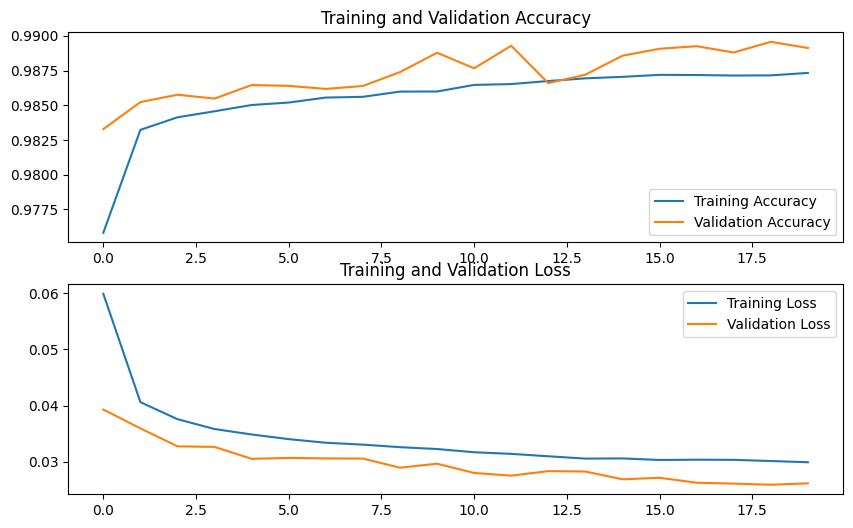

In [43]:
epochs = history1.history['loss']
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(10, 6), dpi=100)
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("graph_CNNLSTM1_20_epoch.png")
plt.show()

# Prediction

In [44]:
#  check the model performance on test data
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

7581/7581 [==============================] - 45s 6ms/step - loss: 0.0263 - accuracy: 0.9890
accuracy: 98.90%


In [45]:
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.026346908882260323
Test accuracy: 0.9889600276947021


In [46]:
# predict
predictions = model.predict(X_test)


  12/7581 [..............................] - ETA: 35s  

2023-07-24 08:10:03.353159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-24 08:10:03.354732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-24 08:10:03.356781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7581/7581 [==============================] - 33s 4ms/step


In [47]:
predictions.shape

(242573, 2)

In [48]:
pred = np.argmax(predictions, axis = 1)[:20]
label = np.argmax(y_test,axis = 1)[:20]
print("Predicted Class: {}".format(pred))
print("Actual label: {}".format(label))

Predicted Class: [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
Actual label: [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


# Confustion Matrix

7581/7581 [==============================] - 36s 5ms/step


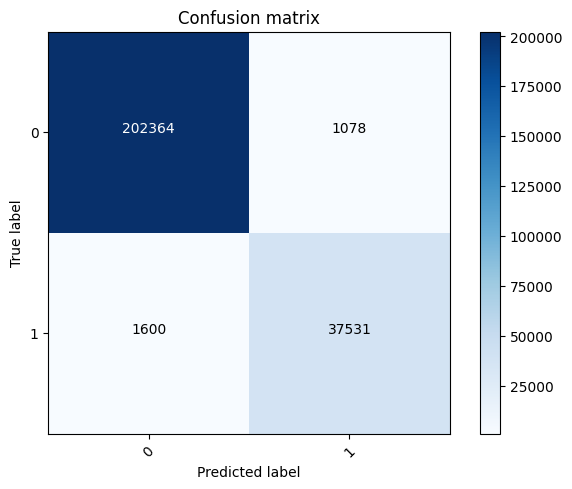

In [49]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)



# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

# Now, lets which category has much incorrect predictions

Text(0, 0.5, 'Fraction classified incorrectly')

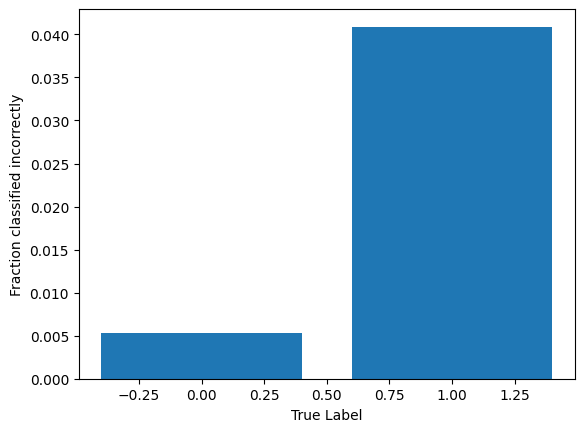

In [50]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(2),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

# Classificaiton report

In [51]:
confusion_mtx

array([[202364,   1078],
       [  1600,  37531]])

In [52]:
confusion_mtx.shape

(2, 2)

In [53]:
y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, Y_pred))

7581/7581 [==============================] - 33s 4ms/step
Confusion Matrix
[[202364   1078]
 [  1600  37531]]


In [54]:
TP = confusion_mtx[0][0]
FP = confusion_mtx[0][1]
FN = confusion_mtx[1][0]
TN = confusion_mtx[1][1]

TP, FP, FN, TN

(202364, 1078, 1600, 37531)

In [55]:
np.argmax(y_test[:10],axis=1)

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [56]:
Y_pred[:10]

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [57]:
def performance_evaluation(TP, FP, FN, TN):
    Accuracy  = (TP+TN)/(TP+TN+FP+FN)
    Precision = TP/(TP + FP)
    Recall = TP/(TP+FN)
    F1_Score = 2 * (Precision * Recall)/(Precision + Recall)
    print("Accuracy: ", Accuracy)
    print("Precision: ", Precision)
    print("Recall: ", Recall)
    print("F1_Score: ", F1_Score)

performance_evaluation(TP, FP, FN, TN)

Accuracy:  0.9889600244050245
Precision:  0.9947011924774629
Recall:  0.99215547841776
F1_Score:  0.9934267045649794
